# Learning Canonical Transformations to Conserved Quantities

## Neumann Hamiltonian

We consider the integrable Hamiltonian

$$
H = \frac{1}{4}\sum_{\alpha,\beta} J_{\alpha\beta}^2 + \frac{1}{2}\sum_\alpha k_\alpha x_\alpha^2
$$

with $J_\alpha\beta = x_\alpha p_\beta - x_\beta p_\alpha$ is the (generalized) angular momentum. The constants of motion are

$$
I_\alpha = x_\alpha^2 + \sum_{\beta\neq \alpha} \frac{J_{\alpha\beta}^2}{k_\alpha-k_\beta}
$$

for $k_\alpha$ all different. We have

$$
H = \frac{1}{2}\sum_\alpha k_\alpha I_\alpha
$$

And

$$
\sum_\alpha x_\alpha^2 = \sum_\alpha I_\alpha,
$$

so that motion is confined to the sphere $S^{N-1}$.

## Seeking Constants of Motion

We are going to seek a canonical transformation to variables $q_\alpha$, $\pi_\alpha$ in which the radial coordinates

$$
\rho_\alpha = \sqrt{q_\alpha^2 + \pi_\alpha^2}
$$

are conserved. This means that we express the transformed Hamiltonian as $H'(q,\pi)\equiv H(x(q,\pi), p(q,\pi))$ and then try to set

$$
q_\alpha \dot q_\alpha +\pi_\alpha \dot \pi_\alpha=q_\alpha \frac{\partial H'}{\partial \pi_\alpha}-\pi_\alpha \frac{\partial H'}{\partial q_\alpha}=0,
$$

which suggests the loss function

$$
\ell(q,\pi) = \sum_\alpha \left(q_\alpha \frac{\partial H'}{\partial \pi_\alpha}-\pi_\alpha \frac{\partial H'}{\partial q_\alpha}\right)^2,
$$

which could be evaluated e.g. on i.i.d. Gaussian variates. Compared to the trajectory approach:

1. We don't need to solve an ODE, but
2. We do need to differentiate to find the gradients.

In [1]:
import sys
sys.path.append("../")
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import matplotlib.pyplot as plt

In [2]:
from hamiltonians import parameterized_neumann
from models import SymplecticAdditiveCoupling, LinearSymplecticTwoByTwo, IrrotationalMLP, SymplecticExchange, Chain
from utils import visualize_chain_bijector_1d, extract_q_p, join_q_p, is_symplectic, run_eagerly, BaseDistributionNormal
from utils import hamiltonian_traj

In [3]:
# tf.enable_eager_execution()
sess = tf.InteractiveSession()
tf.set_random_seed(0)

In [4]:
N = 3
ks = [0.1 , 0.2, 0.3] # Just to fix some values
ks_tensor = tf.constant(ks, dtype=tf.float32, name="ks")

## Form Transformation by Chaining Bijectors

The idea is to map _from_ trajectories _to_ the phase plane of action angle variables, imposing the condition that the distribution factorizes.

In [5]:
# Suppress the warning till they fix this:
# lib/python3.5/site-packages/tensorflow/python/util/tf_inspect.py:75: 
# DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
import warnings
warnings.filterwarnings("ignore")

In [6]:
DTYPE=tf.float32
NP_DTYPE=np.float32
settings = {
    'hamiltonian': parameterized_neumann(ks_tensor),  
    'd': N,               # space dimension
    'num_particles': 1,   # number of particles
    'batch_size': 1024,   # Mini batch size 
    'stack_size': 2}      # Size of the stack of bijectors

Here we try modeling with:

1. `IrrotationalMLP`, which directly generates an irrotational vector field, without using autodifferentiation.

2. `LinearSymplecticTwoByTwo`, which learns linear symplectic transformations on each conjugate pair. 

There is freedom to choose different activations here. Could use traditional NN nonlinearities or simpler things like `tf.square`. Since our loss now depends on gradients, should chose a smooth activation.

We don't really need squeeze, as the linear transformation includes this, so we just use NICE.

Seem to be important to do `SymplecticExchange` (an even number of times).

In [7]:
bijectors = []
for _ in range(settings['stack_size']):
    bijectors.extend([SymplecticExchange(),
                      SymplecticAdditiveCoupling(shift_model=IrrotationalMLP(activation=tf.nn.tanh, width=32)),
                      LinearSymplecticTwoByTwo()])
model = Chain(bijectors)

## Form the Loss

In [8]:
with tf.name_scope("loss"):
    # Sample
    base_dist = BaseDistributionNormal(settings)
    z_samples = base_dist.sample(settings['batch_size'])    
    # Compute grads H'
    Hprime = settings['hamiltonian'](model(z_samples))
    Hprime_grads = tf.gradients(Hprime, z_samples)[0]
    # form loss
    q, p = extract_q_p(z_samples)
    q_grads, p_grads = extract_q_p(Hprime_grads)
    loss = tf.reduce_mean(tf.square(q * p_grads - p * q_grads))

Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`


## Train

In [9]:
step = tf.get_variable("global_step", [], tf.int64, tf.zeros_initializer(), trainable=False)
train_op = tf.train.AdamOptimizer(1e-3).minimize(loss, global_step=step)

Add some summaries for tracking with TensorBoard

In [10]:
tf.summary.scalar("loss_function", tf.reshape(loss, []))

<tf.Tensor 'loss_function:0' shape=() dtype=string>

Monitor training with `tensorboard --logdir logging/`

In [11]:
tf.contrib.training.train(train_op, logdir="../logging", save_checkpoint_secs=60)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into ../logging/model.ckpt.
INFO:tensorflow:global_step/sec: 97.1634
INFO:tensorflow:global_step/sec: 193.08
INFO:tensorflow:global_step/sec: 136.219
INFO:tensorflow:global_step/sec: 146.989
INFO:tensorflow:global_step/sec: 162.439
INFO:tensorflow:global_step/sec: 179.587
INFO:tensorflow:global_step/sec: 198.075
INFO:tensorflow:global_step/sec: 184.368
INFO:tensorflow:global_step/sec: 223.92
INFO:tensorflow:global_step/sec: 132.45
INFO:tensorflow:global_step/sec: 194.816
INFO:tensorflow:global_step/sec: 139.75
INFO:tensorflow:global_step/sec: 146.757
INFO:tensorflow:global_step/sec: 165.52
INFO:tensorflow:global_step/sec: 265.409
INFO:tensorflow:global_step/sec: 202.012
INFO:tensorflow:global_step/sec: 165.278
INFO:tensorflow:global_step/sec: 183.515
INFO:tensorflow:global_step/sec: 1

KeyboardInterrupt: 

## Look at the Learned Representation

Load the saved model. If not training, first evaluate all cells _except_ for those in the __Train__ section. 

In [12]:
traindir = "../logging"
saver = tf.train.Saver()

In [13]:
ckpt_state = tf.train.get_checkpoint_state(traindir)
saver.restore(sess, ckpt_state.model_checkpoint_path)

INFO:tensorflow:Restoring parameters from ../logging/model.ckpt-10520


How do the trajectories look in the phase planes of the new variables? 

In [14]:
from utils import hamiltonian_traj
from importlib import reload
import utils
reload(utils)

<module 'utils' from '../utils.py'>

In [15]:
init_state = tf.reshape(base_dist.sample(1)[0], (settings['d']*settings['num_particles']*2,))
traj = sess.run(hamiltonian_traj(settings['hamiltonian'], init_state, settings, time=20))
x1, y1, x2, y2, x3, y3 = traj.T

In [16]:
trans_traj = sess.run(model.inverse(tf.reshape(traj, [-1,settings['d'],settings['num_particles'],2])))
q1, p1, q2, p2, q3, p3 = np.reshape(trans_traj, (-1,settings['d']*settings['num_particles']*2,)).T

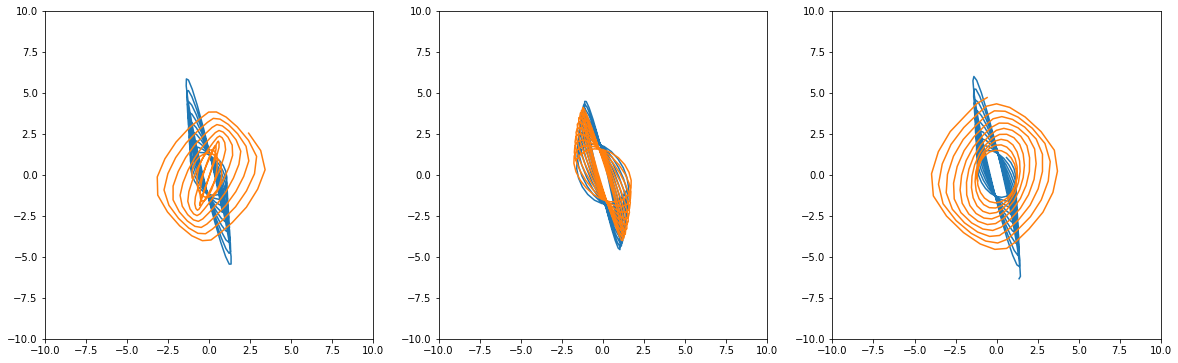

In [17]:
plt.figure(figsize=(20,20))

plt.subplot(1, 3, 1)
plt.plot(x1, y1)
plt.plot(q1, p1)
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.gca().set_aspect('equal', adjustable='box')

plt.subplot(1, 3, 2)
plt.plot(x2, y2)
plt.plot(q2, p2)
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.gca().set_aspect('equal', adjustable='box')

plt.subplot(1, 3, 3)
plt.plot(x3, y3)
plt.plot(q3, p3)
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.gca().set_aspect('equal', adjustable='box')